In [74]:
import seaborn as sns
import pandas as pd
from googleapiclient.discovery import build

In [75]:
api_key="" # remove api key before posting

list_channel_id=[
    'UCnz-ZXXER4jOvuED5trXfEA', 
    'UCLLw7jmFsvfIVaUFsLs8mlQ',
    'UCiT9RITQ9PW6BhXK0y2jaeg',
    'UC7cs8q-gJRlGwj4A8OmCmXg',
    'UC2UXDak6o7rBm23k3Vv5dww'
]

youtube=build('youtube','v3',developerKey=api_key)

## Function to get channel stats

In [76]:
def get_channel_stats(youtube,channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()

    repeated_code = response['items'][0]

    data = dict(
        channel_name=repeated_code['snippet']['title'],
        subscribers=repeated_code['statistics']['subscriberCount'],
        views=repeated_code['statistics']['viewCount'],
        total_videos=repeated_code['statistics']['videoCount'],
        playlist=repeated_code['contentDetails']['relatedPlaylists']['uploads']
                )

    return data


# df = dataframe with channel details

In [77]:
data=list(map(lambda x: get_channel_stats(youtube,x), list_channel_id))

df=pd.DataFrame(data,index=range(1,len(data)+1))
df

,channel_name,subscribers,views,total_videos,playlist
1,techTFQ,185000,8967745,87,UUnz-ZXXER4jOvuED5trXfEA
2,Luke Barousse,331000,15133246,133,UULLw7jmFsvfIVaUFsLs8mlQ
3,Ken Jee,240000,7881845,273,UUiT9RITQ9PW6BhXK0y2jaeg
4,Alex The Analyst,435000,16970599,201,UU7cs8q-gJRlGwj4A8OmCmXg
5,Tina Huang,509000,21564791,121,UU2UXDak6o7rBm23k3Vv5dww


# cleaning the df dataframe

In [78]:
df.subscribers = pd.to_numeric(df.subscribers)
df.views = pd.to_numeric(df.views)
df.total_videos = pd.to_numeric(df.total_videos)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 1 to 5
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   channel_name  5 non-null      object
 1   subscribers   5 non-null      int64 
 2   views         5 non-null      int64 
 3   total_videos  5 non-null      int64 
 4   playlist      5 non-null      object
dtypes: int64(3), object(2)
memory usage: 332.0+ bytes


# exploring the data

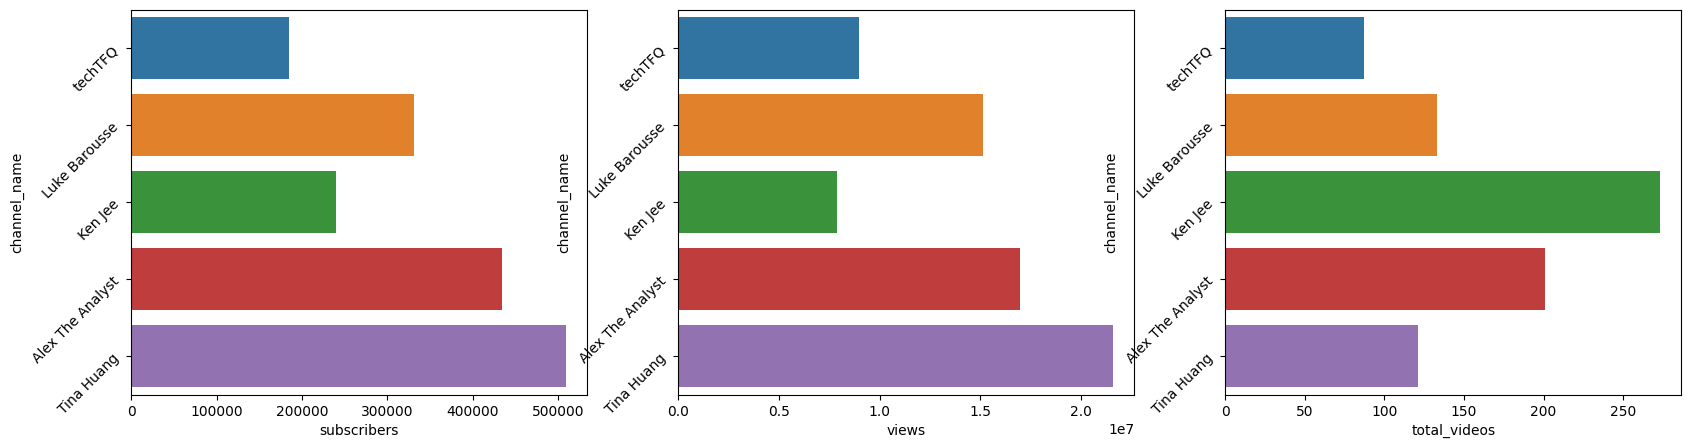

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

for x in df.columns[1:4]:
    num = df.columns.get_loc(x) # to get the location of column?

    plt.subplot(1,3,num)
    sns.barplot(x=df[x], y=df[df.columns[0]])
    plt.yticks(rotation=45)


# Extracting Video Ids

In [80]:
def get_video_id(youtube, playlist_Id,pg_token=''):
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_Id,
        maxResults=50,
        pageToken=pg_token
    )
    response = request.execute()

    list_video_id=list(map(lambda x: x['contentDetails']['videoId'], response['items']))
    nextPageToken = response.get('nextPageToken')

    while nextPageToken:
        return list_video_id + get_video_id(youtube, playlist_Id, pg_token=nextPageToken)

    return list_video_id

In [81]:
video_ids=list(map(lambda x: get_video_id(youtube, x),df.playlist))

In [82]:
def get_data(x):
    channelTitle_ = x['snippet']['channelTitle']
    Title_ = x['snippet']['title']
    Published_date_=x['snippet']['publishedAt']
    Views_= x['statistics']['viewCount']
    Likes_ = x['statistics']['likeCount']
    Comments_ = x['statistics']['commentCount'] 

    dicts={
        'channelTitle': channelTitle_,
        'Title': Title_,
        'Published_date': Published_date_,
        'Views': Views_,
        'Likes': Likes_,
        'Comments': Comments_
    }
    return dicts


def video_details(youtube, video_id, list_num, start_point=0, end_point=50):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=','.join(video_id[list_num][start_point:end_point])
    )
    response = request.execute()

    data=list(map(lambda x :  get_data(x),response['items']))
    while end_point<len(video_id[list_num]):
        return data + video_details(youtube, video_id, list_num, start_point=start_point+50, end_point=end_point+50)

    return data


list_all_video_details=list(map(lambda index: video_details(youtube, video_ids, index), range(len(video_ids))))


# 1) Creating collection of dataframe in a list 
# 2) Creating a common dataframe 

In [165]:
df_collection=[]
for seprate_yt_details in list_all_video_details:
    df_dummy= pd.DataFrame(seprate_yt_details)
    df_collection.append(df_dummy)

merged_df=pd.concat([x for x in df_collection],axis=0)

# Cleaning the Data 

In [166]:

def cleaning_data(df,channel_name):
    temp_df = pd.to_datetime(df.Published_date)
    df['Date']=temp_df.dt.date
    df['Time']=temp_df.dt.time
    df.drop('Published_date',inplace=True,axis=1)
    df[['Views', 'Likes', 'Comments']]=df[['Views', 'Likes', 'Comments']].apply(pd.to_numeric)
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    df.to_excel(f'{channel_name}.xlsx')

# cleaning data of seprate dataframe
for x in df_collection:
    cleaning_data(x, x.iloc[0, 0])

# cleaning the main common dataframe
cleaning_data(merged_df,'Comparing_all')


# Top 10 Videos comparison

In [ ]:
def Comparing_videos():
    df_all = pd.DataFrame()
    for x in merged_df.channelTitle.unique():
        temp_df_=(merged_df[merged_df.channelTitle == x]).sort_values('Views',ascending=False).head(10)
        df_all = pd.concat([df_all, temp_df_], axis=0)
    plt.title('Comparing Top 10 Videos of all YT-Channel')
    sns.scatterplot(x=df_all.Likes, y=df_all.Views, hue=df_all.channelTitle)

C:\Users\Dell\AppData\Local\Temp\ipykernel_32900\4168838920.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, graph_position)


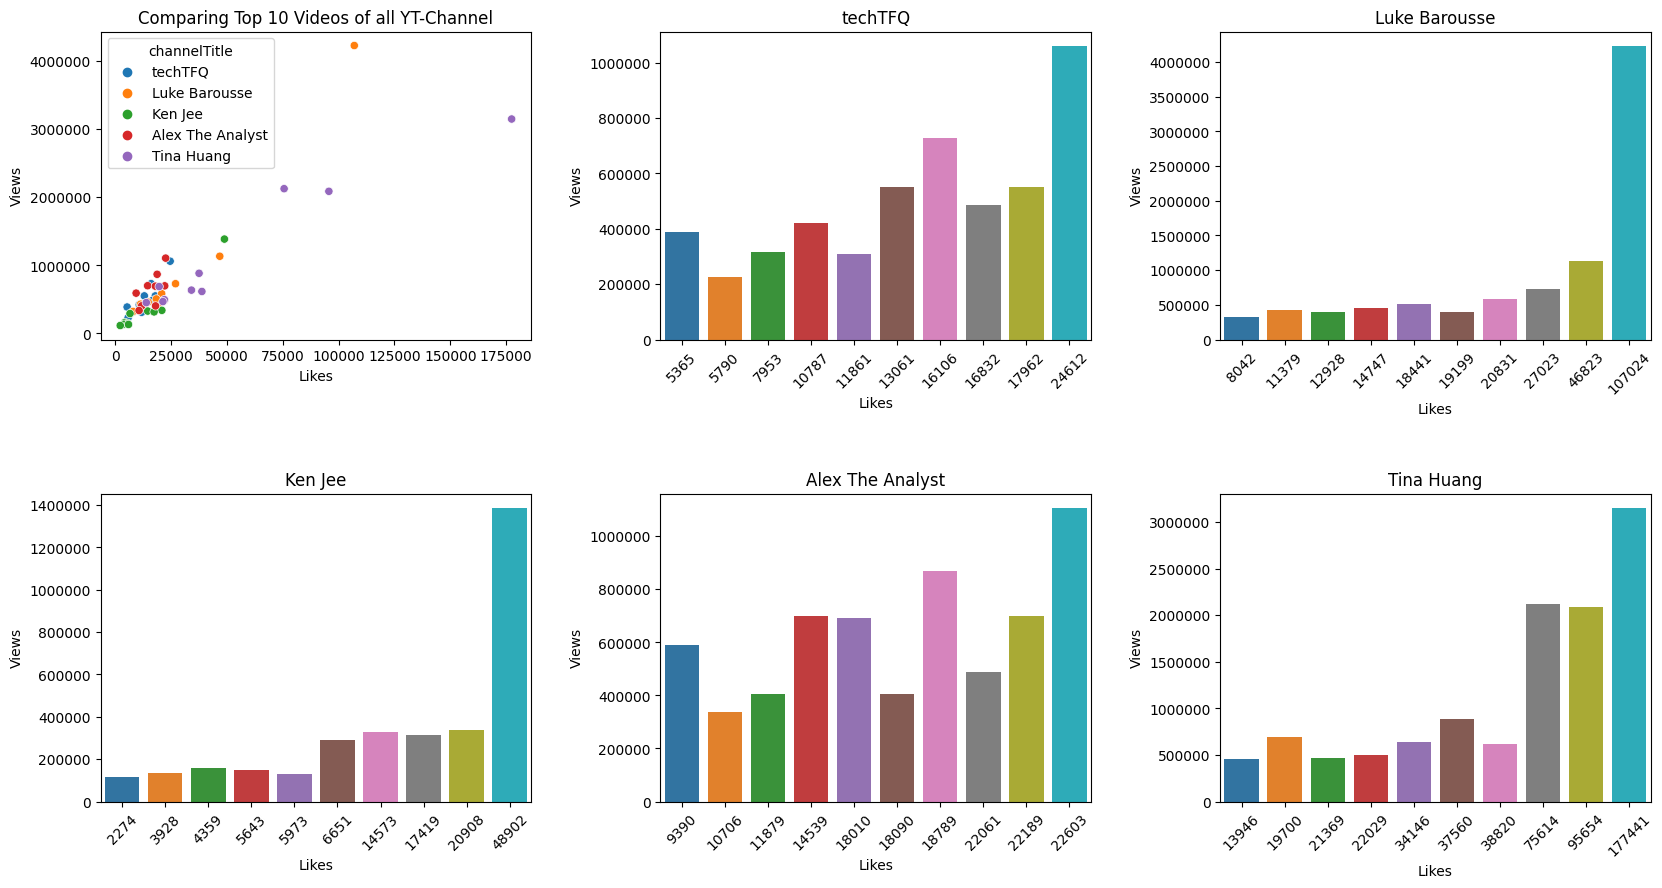

In [317]:
def top_10_video(graph_position,df=None):
    global switch
    
    plt.ticklabel_format(style='plain', axis='y')

    if switch:
        switch = False
        plt.subplot(2, 3, graph_position)
        return Comparing_videos()
    else:
        sorted_df=df.sort_values('Views',ascending=False)
        sns_df=sorted_df.head(10)
        plt.subplot(2, 3, graph_position)
        return sns.barplot(y=sns_df.Views, x=sns_df.Likes)

switch=True # require to switch for first graph

fig=plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)


top_10_video(1) # to bypass the first df as we are trying to call Comparing_videos fnc in this

for num, x in enumerate(df_collection):
    ax=top_10_video(num+2,x)
    plt.title(f'{x.iloc[0,0]}')
    plt.xticks(rotation=45)
    plt.ticklabel_format(style='plain', axis='y') # had to call 2 times bcz either first graph or last graph y axis was not working as expected

plt.show()

In [ ]:
# Avg mnthly post
# Avg Weekly post
    # best time to post per week   

# best title